In [191]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FixedLocator, FixedFormatter
from matplotlib.colors import LinearSegmentedColormap
from pathlib import Path
import json


import xcoll as xc
import xtrack as xt

In [192]:
def df_to_delta(df):
    sps_gtr = 17.95
    sps_g0 = 27.643
    f0 = 200e6
    eta = 1/sps_gtr**2 - 1/sps_g0**2
    return -df/(f0*eta)

def dr_to_delta(dR):
    dR /= 1000
    sps_radius = 1100.
    sps_gtr = 17.95
    return dR/sps_radius*sps_gtr*sps_gtr

In [193]:
def interpolate_50_val(xvals, yvals):
    if np.any(yvals <= 0.5):  # ensure the curve actually crosses 0.5
        idx_above = np.where(yvals > 0.5)[0][-1]   # last index above 0.5
        idx_below = idx_above + 1                  # first index below 0.5

        # Linear interpolation for more accuracy
        x50 = np.interp(0.5, [yvals[idx_above], yvals[idx_below]],
                            [xvals[idx_above], xvals[idx_below]])
        return x50
    else:
        print("Warning: The curve does not cross 0.5")
        return None

# Directories of bumps per quad and plane

In [194]:
studies_results_dir = Path('/Users/lisepauwels/sps_simulations/Studies/OffMomBumpScans/studies_results/')

subdirs = {quad.name : {plane.name : [bump for bump in Path(studies_results_dir/quad/plane).iterdir()] for plane in Path(studies_results_dir/quad).iterdir()} for quad in studies_results_dir.iterdir()}

# Midpoints computation

In [197]:
intensity_data = {}
midpoints = {}
for quad in subdirs:
    intensity_data[quad] = {}
    midpoints[quad] = {}
    for plane in subdirs[quad]:
        bumps = [float(bump.name) for bump in subdirs[quad][plane]]

        bumps, subdirs[quad][plane] = zip(*sorted(zip(bumps, subdirs[quad][plane])))
        bumps = np.array(bumps)
        subdirs[quad][plane] = np.array(subdirs[quad][plane])
        print(f'Quad: {quad}, Plane: {plane}, Bumps: {bumps}')
        intensity_data[quad][plane] = {}
        midpoints[quad][plane] = {}

        for bump, bump_dir in zip(bumps, subdirs[quad][plane]):

            # Load intensity loss data
            with open(bump_dir/'IntensityLoss.json', 'r') as f:
                intensity_loss_dict = json.load(f)

            turns = list(intensity_loss_dict.keys())
            num_particles = intensity_loss_dict['num_particles']
            sweep_per_turn = intensity_loss_dict['sweep_per_turn']
            turns.remove('num_particles')
            turns.remove('sweep_per_turn')
            intensity_loss_dict.pop('num_particles', None)
            intensity_loss_dict.pop('sweep_per_turn', None)
            intensity_data[quad][plane][bump] = {}

            turns, counts = zip(*sorted(zip(map(int, turns), intensity_loss_dict.values())))
            intensity_data[quad][plane][bump]['turns'] = np.array(list(turns), dtype=int)
            intensity_data[quad][plane][bump]['num_particles'] = num_particles
            intensity_data[quad][plane][bump]['sweep_per_turn'] = sweep_per_turn

            
            intensity_data[quad][plane][bump]['counts'] = np.array(list(intensity_loss_dict.values()), dtype=int)

            # Compute deltas
            deltas = df_to_delta(sweep_per_turn * intensity_data[quad][plane][bump]['turns'])
            intensity_data[quad][plane][bump]['deltas'] = deltas
            
            deltas = np.concatenate((np.array([0]), deltas))
            counts = np.concatenate((np.array([1]), intensity_data[quad][plane][bump]['counts']))

            # Compute midpoint
            midpoints[quad][plane][bump] = interpolate_50_val(deltas, 1 - np.cumsum(counts) / num_particles) * 1e3


Quad: qd.43510, Plane: DPneg, Bumps: [-20. -18. -16. -14. -12. -10.  -8.  -6.  -4.  -2.   0.   2.  20.]
Quad: qd.43510, Plane: DPpos, Bumps: [-20.  -2.   0.   2.   4.   6.   8.  10.  12.  14.  16.  18.  20.]
Quad: qd.12510, Plane: DPneg, Bumps: [-20. -18. -16. -14. -12. -10.  -8.  -6.  -4.  -2.   0.   2.  20.]
Quad: qd.12510, Plane: DPpos, Bumps: [-20.  -2.   0.   2.   4.   6.   8.  10.  12.  14.  16.  18.  20.]
Quad: qd.22510, Plane: DPneg, Bumps: [-20. -18. -16. -14. -12. -10.  -8.  -6.  -4.  -2.   0.   2.  20.]
Quad: qd.22510, Plane: DPpos, Bumps: [-20.  -2.   0.   2.   4.   6.   8.  10.  12.  14.  16.  18.  20.]
Quad: qd.33510, Plane: DPneg, Bumps: [-20. -18. -16. -14. -12. -10.  -8.  -6.  -4.  -2.   0.   2.  20.]
Quad: qd.33510, Plane: DPpos, Bumps: [-20.  -2.   0.   2.   4.   6.   8.  10.  12.  14.  16.  18.  20.]
Quad: qd.62510, Plane: DPneg, Bumps: [-20. -18. -16. -14. -12. -10.  -8.  -6.  -4.  -2.   0.   2.  20.]
Quad: qd.62510, Plane: DPpos, Bumps: [-20.  -2.   0.   2.   4.  

# Midpoints plots

## Simulation: Comparison DPpos and DPneg

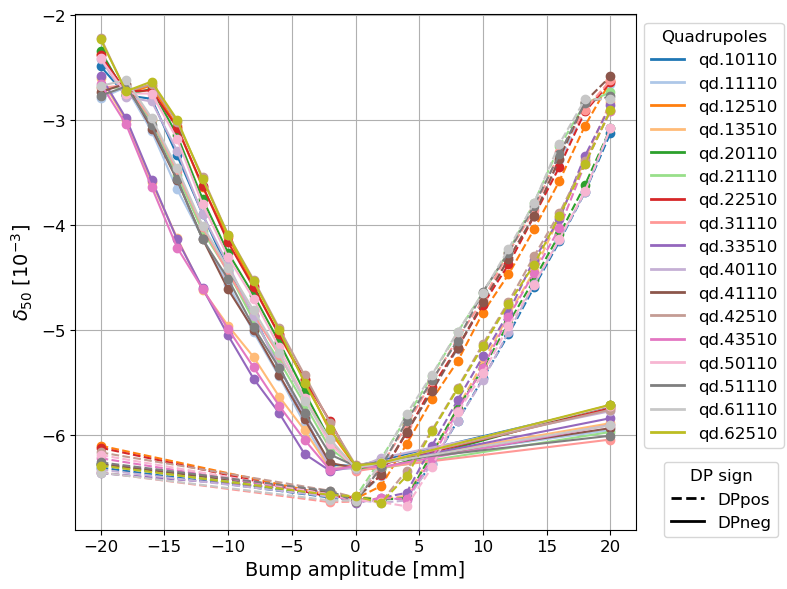

In [303]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
colors = {'qd.20110' : 'royalblue', 'qd.31110' : 'darkviolet', 'qd.50110': 'crimson'}

quads = sorted(
    midpoints.keys(),
    key=lambda name: int(name.split('.')[1])
)
cmap = colormaps['tab20']
colors = {quad : cmap(i %20) for i, quad in enumerate(quads)}
linestyles = {'DPpos' : '--', 'DPneg' : '-'}

for quad in quads:
    for plane in midpoints[quad]:
        bumps = np.array(list(midpoints[quad][plane].keys()))
        mids = np.array(list(midpoints[quad][plane].values()))
        ax.plot(bumps, -np.abs(mids), marker='o', color=colors[quad], linestyle=linestyles[plane])

ax.grid()
ax.set_xlabel('Bump amplitude [mm]', fontsize=14)
ax.set_ylabel(r'$\delta_{50}$ $[10^{-3}]$', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)

color_handles = [
    Line2D([0], [0], color=color, lw=2, label=name)
    for name, color in colors.items()
]

ls_handles = [
    Line2D([0], [0], color='black', linestyle=ls, lw=2, label=ls_name)
    for ls_name, ls in linestyles.items()
]
# ax.legend(title='Quadrupole', fontsize=12)
# legend_quad = ax.legend(handles=color_handles, title='Quadrupoles',
#                     loc='center', bbox_to_anchor=(0.4, 0.85), fontsize=12, title_fontsize=12)
# ax.add_artist(legend_quad)  # keep the first one visible
# legend_dp = ax.legend(handles=ls_handles, title='DP sign',
#                     loc='center', bbox_to_anchor=(0.65, 0.85), fontsize=12, title_fontsize=12)

legend_quad = ax.legend(
    handles=color_handles,
    title='Quadrupoles',
    loc='upper left',
    bbox_to_anchor=(1, 1),  # right side of axes
    fontsize=12,
    title_fontsize=12
)
ax.add_artist(legend_quad)  # keep first one visible

# Second legend (DP sign) under the first one
legend_dp = ax.legend(
    handles=ls_handles,
    title='DP sign',
    loc='lower left',
    bbox_to_anchor=(1.035, -0.03),  # slightly lower, adjust as needed
    fontsize=12,
    title_fontsize=12
)

fig.tight_layout()
plt.savefig('plots/Midpoints_all.png', dpi=300)

## MD: comparison DPpos and DPneg

In [288]:
with open('midpoints.json', 'r') as fid:
    midpoints_md = json.load(fid)

In [273]:
colors = {quad.capitalize() : cmap(i %20) for i, quad in enumerate(midpoints.keys())}

In [280]:
list(colors.keys())[0].capitalize()

'Qd.43510'

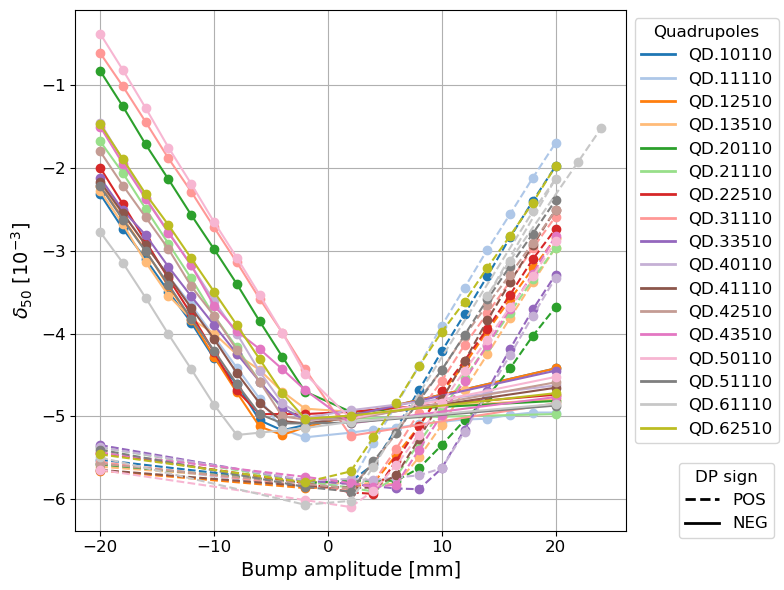

In [305]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
colors = {'QD.20110' : 'royalblue', 'QD.31110' : 'darkviolet', 'QD.50110': 'crimson'}

quads = sorted(
    midpoints.keys(),
    key=lambda name: int(name.split('.')[1])
)
cmap = colormaps['tab20']
colors = {quad.upper() : cmap(i %20) for i, quad in enumerate(quads)}
linestyles = {'POS' : '--', 'NEG' : '-'}

for quad in colors:#['QD.20110', 'QD.31110', 'QD.50110']:
    for plane in ['POS', 'NEG']:
        bumps = list(midpoints_md[f'{quad}_{plane}'].keys())
        midpoints_loc = np.array([np.mean(midpoints_md[f'{quad}_{plane}'][_]) for _ in bumps])
        for i in range(len(bumps)):
            bumps[i] = float(bumps[i])
        mids = dr_to_delta(midpoints_loc)*1e3
        ax.plot(bumps, -np.abs(mids), marker='o', color=colors[quad], linestyle=linestyles[plane])



ax.grid()
ax.set_xlabel('Bump amplitude [mm]', fontsize=14)
ax.set_ylabel(r'$\delta_{50}$ $[10^{-3}]$', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)

color_handles = [
    Line2D([0], [0], color=color, lw=2, label=name)
    for name, color in colors.items()
]

ls_handles = [
    Line2D([0], [0], color='black', linestyle=ls, lw=2, label=ls_name)
    for ls_name, ls in linestyles.items()
]
# ax.legend(title='Quadrupole', fontsize=12)
# legend_quad = ax.legend(handles=color_handles, title='Quadrupoles',
#                     loc='center', bbox_to_anchor=(0.4, 0.85), fontsize=12, title_fontsize=12)
# ax.add_artist(legend_quad)  # keep the first one visible
# legend_dp = ax.legend(handles=ls_handles, title='DP sign',
#                     loc='center', bbox_to_anchor=(0.65, 0.85), fontsize=12, title_fontsize=12)

legend_quad = ax.legend(
    handles=color_handles,
    title='Quadrupoles',
    loc='upper left',
    bbox_to_anchor=(1, 1),  # right side of axes
    fontsize=12,
    title_fontsize=12
)
ax.add_artist(legend_quad)  # keep first one visible

# Second legend (DP sign) under the first one
legend_dp = ax.legend(
    handles=ls_handles,
    title='DP sign',
    loc='lower left',
    bbox_to_anchor=(1.08, -0.03),  # slightly lower, adjust as needed
    fontsize=12,
    title_fontsize=12
)

fig.tight_layout()
plt.savefig('plots/Midpoints_MD_all.png', dpi=300)

## DPneg comparison

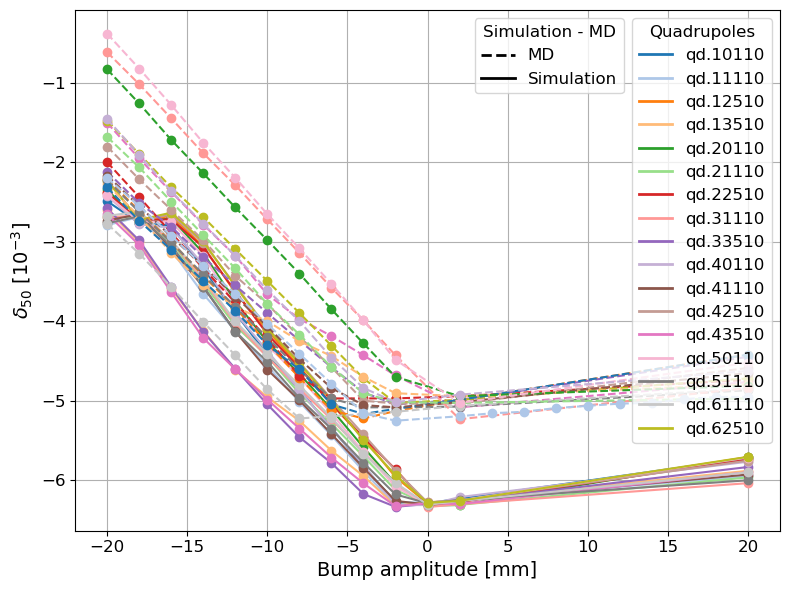

In [306]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
colors = {'qd.20110' : 'royalblue', 'qd.31110' : 'darkviolet', 'qd.50110': 'crimson'}

quads = sorted(
    midpoints.keys(),
    key=lambda name: int(name.split('.')[1])
)
cmap = colormaps['tab20']
colors = {quad : cmap(i %20) for i, quad in enumerate(quads)}

linestyles = {'MD' : '--', 'Simulation' : '-'}

for quad in quads:
    for plane in ['DPneg']:
        bumps = np.array(list(midpoints[quad][plane].keys()))
        mids = np.array(list(midpoints[quad][plane].values()))
        ax.plot(bumps, -np.abs(mids), marker='o', color=colors[quad], linestyle=linestyles['Simulation'])

quads_capt = [q.upper() for q in midpoints.keys()]
for quad in quads_capt: #['QD.20110', 'QD.31110', 'QD.50110']:
    for plane in ['NEG']:
        bumps = list(midpoints_md[f'{quad}_{plane}'].keys())
        midpoints_loc = np.array([np.mean(midpoints_md[f'{quad}_{plane}'][_]) for _ in bumps])
        for i in range(len(bumps)):
            bumps[i] = float(bumps[i])
        mids = dr_to_delta(midpoints_loc)*1e3
        ax.plot(bumps, -np.abs(mids), marker='o', color=colors[quad.lower()], linestyle=linestyles['MD'])

ax.grid()
ax.set_xlabel('Bump amplitude [mm]', fontsize=14)
ax.set_ylabel(r'$\delta_{50}$ $[10^{-3}]$', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)

color_handles = [
    Line2D([0], [0], color=color, lw=2, label=name)
    for name, color in colors.items()
]

ls_handles = [
    Line2D([0], [0], color='black', linestyle=ls, lw=2, label=ls_name)
    for ls_name, ls in linestyles.items()
]
# ax.legend(title='Quadrupole', fontsize=12)
# First legend (Quadrupoles) — upper right
legend_quad = ax.legend(handles=color_handles, title='Quadrupoles',
                        loc='upper right', bbox_to_anchor=(1.0, 1.0),
                        fontsize=12, title_fontsize=12)
ax.add_artist(legend_quad)

# Second legend (Simulation - MD) — just below the first
legend_dp = ax.legend(handles=ls_handles, title='Simulation - MD',
                      loc='upper right', bbox_to_anchor=(0.79, 1),
                      fontsize=12, title_fontsize=12)
fig.tight_layout()
plt.savefig('plots/Midpoints_DPneg_comparison_simMD_all.png', dpi=300)

## DPpos comparison

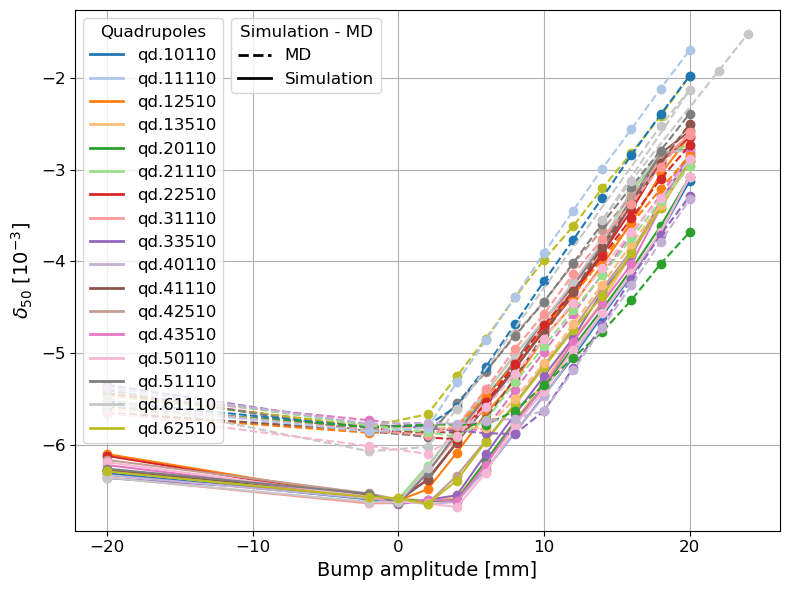

In [307]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
colors = {'qd.20110' : 'royalblue', 'qd.31110' : 'darkviolet', 'qd.50110': 'crimson'}

quads = sorted(
    midpoints.keys(),
    key=lambda name: int(name.split('.')[1])
)

cmap = colormaps['tab20']
colors = {quad : cmap(i %20) for i, quad in enumerate(quads)}

linestyles = {'MD' : '--', 'Simulation' : '-'}

for quad in quads:
    for plane in ['DPpos']:
        bumps = np.array(list(midpoints[quad][plane].keys()))
        mids = np.array(list(midpoints[quad][plane].values()))
        ax.plot(bumps, -np.abs(mids), marker='o', color=colors[quad], linestyle=linestyles['Simulation'])

quads_capt = [q.upper() for q in midpoints.keys()]
for quad in quads_capt: #['QD.20110', 'QD.31110', 'QD.50110']:
    for plane in ['POS']:
        bumps = list(midpoints_md[f'{quad}_{plane}'].keys())
        midpoints_loc = np.array([np.mean(midpoints_md[f'{quad}_{plane}'][_]) for _ in bumps])
        for i in range(len(bumps)):
            bumps[i] = float(bumps[i])
        mids = dr_to_delta(midpoints_loc)*1e3
        ax.plot(bumps, -np.abs(mids), marker='o', color=colors[quad.lower()], linestyle=linestyles['MD'])

ax.grid()
ax.set_xlabel('Bump amplitude [mm]', fontsize=14)
ax.set_ylabel(r'$\delta_{50}$ $[10^{-3}]$', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)

color_handles = [
    Line2D([0], [0], color=color, lw=2, label=name)
    for name, color in colors.items()
]

ls_handles = [
    Line2D([0], [0], color='black', linestyle=ls, lw=2, label=ls_name)
    for ls_name, ls in linestyles.items()
]
# ax.legend(title='Quadrupole', fontsize=12)
# First legend (Quadrupoles) — upper left
legend_quad = ax.legend(handles=color_handles, title='Quadrupoles',
                        loc='upper left', bbox_to_anchor=(0.0, 1.0),
                        fontsize=12, title_fontsize=12)
ax.add_artist(legend_quad)

# Second legend (Simulation - MD) — just below the first
legend_dp = ax.legend(handles=ls_handles, title='Simulation - MD',
                      loc='upper left', bbox_to_anchor=(0.21, 1),
                      fontsize=12, title_fontsize=12)
fig.tight_layout()
plt.savefig('plots/Midpoints_DPpos_comparison_simMD_all.png', dpi=300)

# Intensity plots

Customed colormap

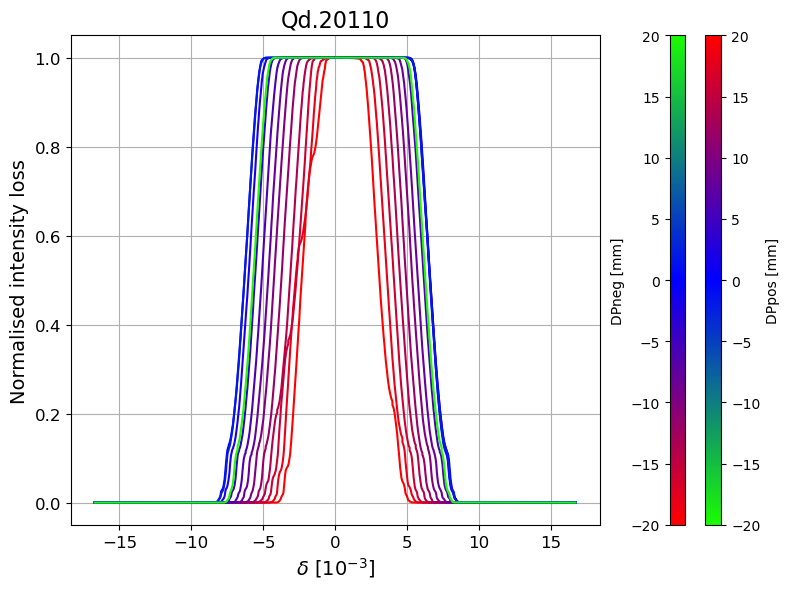

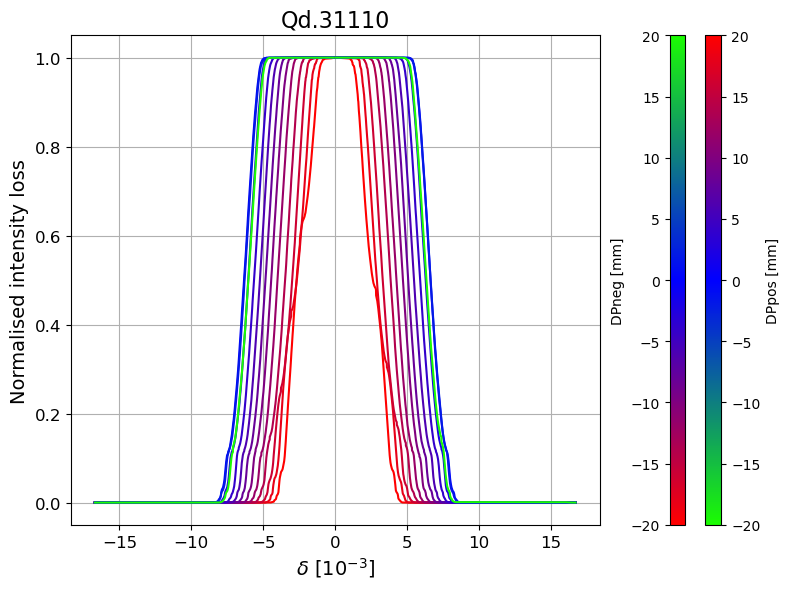

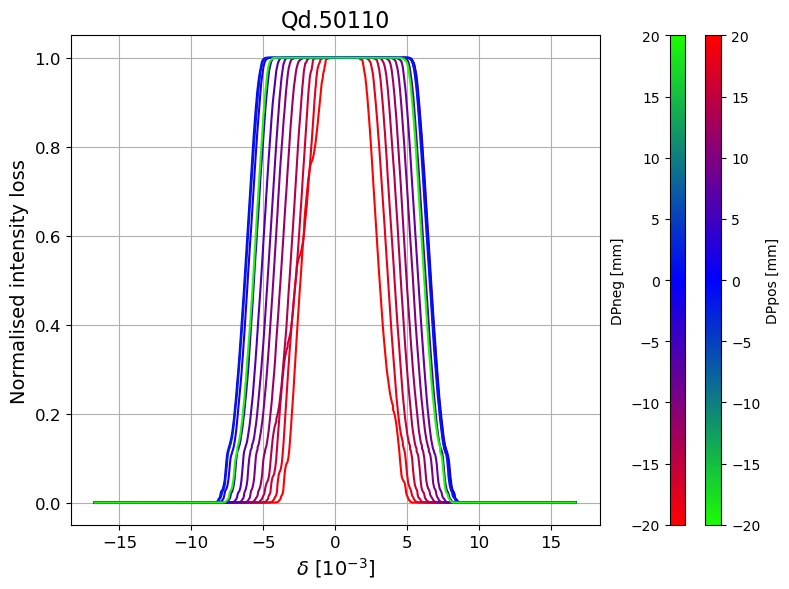

In [153]:
for quad in intensity_data:
    # Create output directory
    savedir = Path(f'/Users/lisepauwels/sps_simulations/Studies/OffMomBumpScans/plots/{quad}/')
    savedir.mkdir(parents=True, exist_ok=True)
    fig, ax = plt.subplots(1,1, figsize=(8,6))

    # Define colormaps and normalizations
    # cmap_pos = LinearSegmentedColormap.from_list('RGB', ['blue', 'green', 'red'])
    # cmap_pos = LinearSegmentedColormap.from_list('RGB', ['green', 'blue', 'red'])
    cmap_pos = LinearSegmentedColormap.from_list('RGB', ["#1bfc02", 'blue', 'red'])
    sc_pos = ScalarMappable(cmap=cmap_pos, norm=norm)
    sc_pos.set_array([])
    # cmap_neg = LinearSegmentedColormap.from_list('RGB', ['red', 'green', 'blue'])
    cmap_neg = LinearSegmentedColormap.from_list('RGB', ['red', 'blue', "#1bfc02"])
    sc_neg = ScalarMappable(cmap=cmap_neg, norm=norm)
    sc_neg.set_array([])

    for plane in intensity_data[quad]:
        bumps = np.array(list(intensity_data[quad][plane].keys()))
        norm = Normalize(vmin=int(bumps.min()), vmax=int(bumps.max()))

        if plane == 'DPpos':
            for bump in reversed(bumps):
                deltas = np.concatenate((np.array([0]), intensity_data[quad][plane][bump]['deltas']))
                counts = np.concatenate((np.array([1]), intensity_data[quad][plane][bump]['counts']))
                survival = 1 - np.cumsum(counts) / intensity_data[quad][plane][bump]['num_particles']
                ax.plot(deltas*1e3, survival, label=f'Bump: {bump} mm', color=cmap_pos(norm(bump)))
        else:
            for bump in bumps:
                deltas = np.concatenate((np.array([0]), intensity_data[quad][plane][bump]['deltas']))
                counts = np.concatenate((np.array([1]), intensity_data[quad][plane][bump]['counts']))
                survival = 1 - np.cumsum(counts) / intensity_data[quad][plane][bump]['num_particles']
                ax.plot(deltas*1e3, survival, label=f'Bump: {bump} mm', color=cmap_neg(norm(bump)))

    
    ax.grid()
    ax.set_xlabel(r'$\delta$ $[10^{-3}]$', fontsize=14)
    ax.set_ylabel('Normalised intensity loss', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_title(f'{quad.capitalize()}', fontsize=16)

    # Divider to place colorbars
    divider = make_axes_locatable(ax)

    # ---- DPneg colorbar (right, ticks/labels on left) ----
    cax_neg = divider.append_axes("right", size="3%", pad=0.7)  # increase pad to move right
    cbar_neg = plt.colorbar(sc_neg, cax=cax_neg)
    cbar_neg.set_label('DPneg [mm]', fontsize=10)
    cbar_neg.ax.yaxis.set_label_position('left')
    cbar_neg.ax.yaxis.set_ticks_position('left')
    cbar_neg.ax.tick_params(axis='y', which='both', direction='out', labelleft=True, labelright=False)

    # ---- DPpos colorbar (right, normal ticks/labels) ----
    cax_pos = divider.append_axes("right", size="3%", pad=0.2)  # increase pad more to separate from DPneg
    cbar_pos = plt.colorbar(sc_pos, cax=cax_pos)
    cbar_pos.set_label('DPpos [mm]', fontsize=10)
    cbar_pos.ax.yaxis.set_label_position('right')
    cbar_pos.ax.yaxis.set_ticks_position('right')
    cbar_pos.ax.tick_params(axis='y', which='both', direction='out', labelleft=False, labelright=True)

    fig.tight_layout()
    plt.savefig(savedir/f'IntensityLoss_{quad}.png', dpi=300)